In [15]:
import json
import os

import torch
import torch.optim as optim
import torch.nn as nn
import torchvision
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from model import ResNet18, LeNet5
from pgd_attack import LinfPGDAttack
from train import train_one_epoch, evaluate

with open('config.json') as config_file:
    config = json.load(config_file)

# randomness control
torch.manual_seed(config['torch_random_seed'])
np.random.seed(config['np_random_seed'])

# GPU check
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

# training parameters
max_num_epochs = config['max_num_epochs']
step_size_start = config['step_size_start']
step_size_schedule = config['step_size_schedule']
step_size_decay = config['step_size_decay']
weight_decay = config['weight_decay']
data_path = config['data_path']
momentum = config['momentum']
batch_size = config['training_batch_size']
dataset = config['dataset']
adv_training = config['train_with_adversary']



In [16]:
# set up data and model
to_tensor = torchvision.transforms.PILToTensor()
to_double = torchvision.transforms.ConvertImageDtype(torch.double)
cifar_transform = torchvision.transforms.Compose([to_tensor,
                                                  to_double])
num_classes = 10
cifar_train_data = torchvision.datasets.CIFAR10(data_path,
                                                transform=cifar_transform,
                                                train=True,
                                                download=True)
cifar_test_data = torchvision.datasets.CIFAR10(data_path,
                                               transform=cifar_transform,
                                               train=False,
                                               download=True)

train_data = torch.utils.data.DataLoader(cifar_train_data,
                                         batch_size=batch_size,
                                         shuffle=True)
test_data = torch.utils.data.DataLoader(cifar_test_data,
                                        batch_size=batch_size,
                                        shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [26]:
n = 8
epsilons = np.linspace(0.001, 0.1, num=n)
adv_acc_results = np.zeros((n, n))
adv_loss_results = np.zeros((n, n))
loss_func = nn.CrossEntropyLoss()
for i in tqdm(range(n)):
    model = LeNet5(num_classes).double().to(device)
    optimizer = optim.SGD(model.parameters(), lr=step_size_start,
                          momentum=momentum, weight_decay=weight_decay)
    lr_schedule = optim.lr_scheduler.StepLR(optimizer, step_size=step_size_schedule,
                                            gamma=step_size_decay)
    # DEFENDER
    defender = LinfPGDAttack(model,
                             epsilons[i],
                             config['num_steps'],
                             config['step_size'],
                             config['random_start'],
                             device)
    for e in range(max_num_epochs):
        train_one_epoch(model, loss_func, optimizer, train_data, defender, device)
    for j in range(n):
        # ATTACKER
        attacker = LinfPGDAttack(model,
                                epsilons[j],
                                config['num_steps'],
                                config['step_size'],
                                config['random_start'],
                                device)
        _, (adv_loss, adv_acc) = evaluate(model,
                                          loss_func,
                                          test_data,
                                          attacker,
                                          device)
        adv_loss_results[i][j] = adv_loss
        adv_acc_results[i][j] = adv_acc

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [12:51<00:00, 96.43s/it]


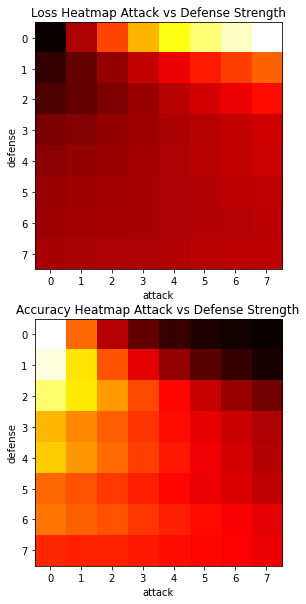

In [27]:
# plot heatmap of accuracy
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
ax1.imshow(adv_loss_results, cmap='hot')
ax1.set_title('Loss Heatmap Attack vs Defense Strength')
ax1.set_xlabel('attack')
ax1.set_ylabel('defense')
ax2.imshow(adv_acc_results, cmap='hot')
ax2.set_title('Accuracy Heatmap Attack vs Defense Strength')
ax2.set_xlabel('attack')
ax2.set_ylabel('defense')

plt.show()